In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shared_utils
from cost_per_bus_utils import *
from IPython.display import Markdown, display
from matplotlib.ticker import ScalarFormatter
from scipy.stats import zscore

In [2]:
Markdown(summary)


## Summary
This analysis examines the cost of buses for transit agencies across the county. Specifically, to observe the variation of bus cost for propulsion type and bus sizes.

Data was compiled from three data sources:

1. 130 projects from FTA Bus and Low- and No-Emission Grant Awards press release (federally funded, nationwide data)
2. 124 projects TIRCP project data (state-funded, California only)
3. 35 projects DGS usage report for all procurements from California agencies purchasing from New Flyer and Portera Inc..

The compiled dataset includes **289** total transit related projects. However, the initial dataset included projects that encompassed bus procurement and other components such as charging installation and facility construction, as well as non-bus related projects (ferries, trains). The dataset was filtered to exclude projects that were not bus related, indicated 0 buses procured, and projects that contained construction/installation work. **87** projects remained that specified the number of buses to procure and explicitly described procuring buses (bus only projects). 

Number of bus only contracts from each dataset 
- FTA: **43**
- TIRCP: **9**
- DGS: **35**


The remaining bus only projects were categorized into different propulsion types and bus sizes, a “cost per bus” value was calculated, and outliers removed.

A overall summary is provided below:
- Total projects: **298**
- Number of projects with mix bus procurement and other components, also non-bus projects: **204** 
- Number of bus only projects: **87**
- Total dollars awarded to bus only projects: **`$831,843,715.00`**
- Total number of buses: **1353.0**
- Most common propulsion type procured for bus only projects: **BEB** at **30** projects
- Number of ZEB buses* procured: **452.0**
- Number of non-ZEB buses** procured: **575.0**
- Overall average cost per bus (ZEB & non-ZEB) is `$792,635.34` (std `$396,712.61`)
- ZEB average cost per bus is `$1,056,659.30` (std `$253,737.82`)
- Non-ZEB average cost per bus is `$528,106.49` (std `$315,932.20`) 

`*`ZEB buses include: zero-emission (not specified), electric (not specified), battery electric, fuel cell electric

`**`Non-ZEB buses include: CNG, ethanol, low emission (hybrid, propane), diesel, gas.


Below are key charts that visualize more findings:





## All buses (ZEB and non-ZEB) cost/bus distribution curve.
This chart shows the cost per bus distribution of all bus only projects.


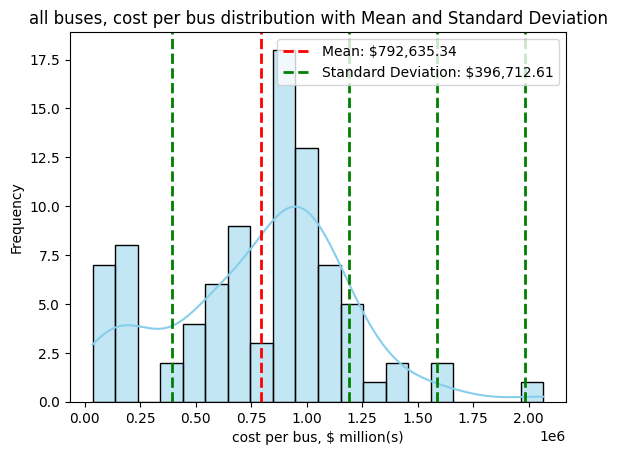

In [3]:
# all bus distribution
display(Markdown(all_bus_desc))

dist_curve(
    df=no_outliers,
    mean=cpb_mean,
    std=cpb_std,
    title="all buses, cost per bus distribution",
    xlabel="cost per bus, $ million(s)",
)


## ZEB only  cost/bus Distribution Chart. 
Chart of projects with zero-emission, electric, battery electric, hydrogen fuel cell bus procurements.


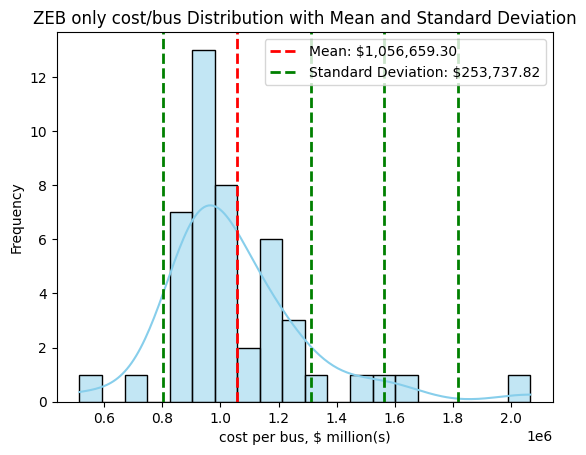

In [4]:
# ZEB dist curve
display(Markdown(zeb_desc))

dist_curve(
    df=zeb_no_outliers,
    mean=zeb_only_mean,
    std=zeb_only_std,
    title="ZEB only cost/bus Distribution",
    xlabel="cost per bus, $ million(s)",
)


## non-ZEB cost/bus Distribution. 
Chart of projects with non-ZEB bus procurement (hybrids, diesel, cng)
This distrubtion is wider than the ZEB projects.

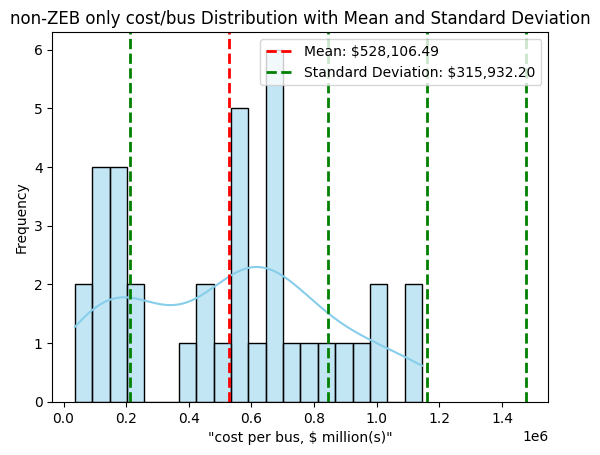

In [5]:
# non_zeb distribution
display(Markdown(non_zeb_desc))

dist_curve(
    non_zeb_no_outliers,
    non_zeb_only_mean,
    non_zeb_only_std,
    title="non-ZEB only cost/bus Distribution",
    xlabel='"cost per bus, $ million(s)"',
)


## Cost per bus by propulsion type. 


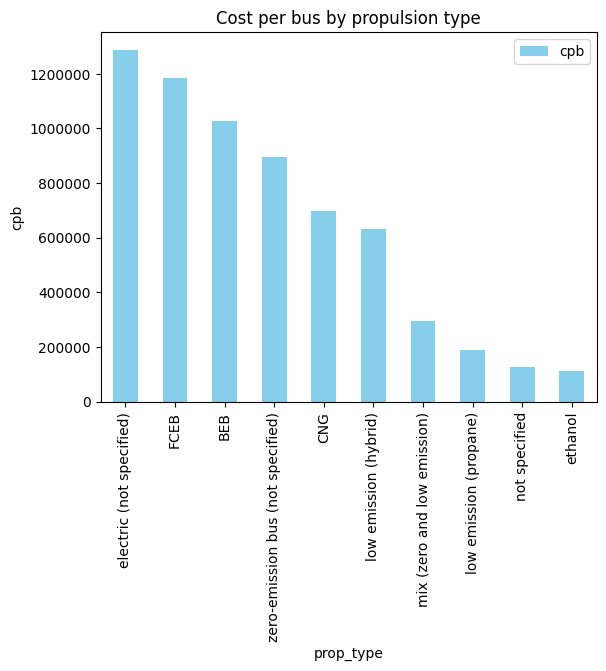

In [6]:
# COST PER BUS BY PROP TYPE
display(Markdown(cpb_prop_type_desc))
make_chart("cpb", "Cost per bus by propulsion type", x_col="prop_type", data=prop_agg)


## Bus count by propulsion type. 


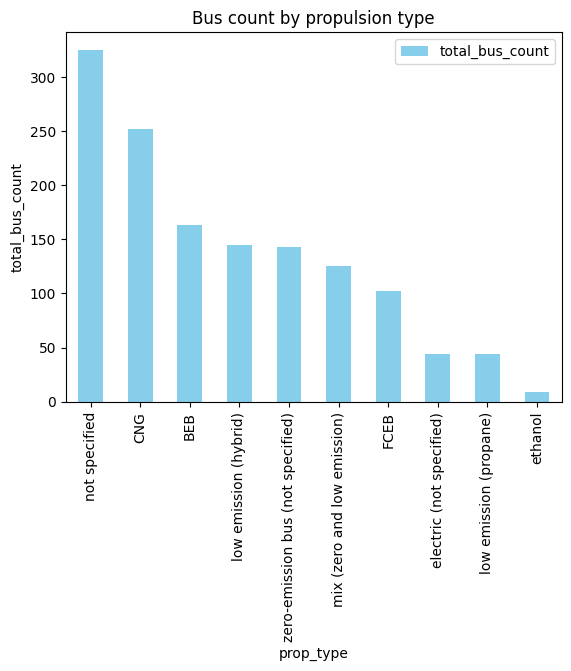

In [7]:
# bus count BY PROP TYPE
display(Markdown(bus_count_prop_type_desc))
make_chart(
    "total_bus_count", 
    "Bus count by propulsion type",
    x_col="prop_type",
    data=prop_agg
)

In [8]:
display(Markdown(conclusion))


## Conclusion
Based on the findings so far in bus only projects, there is evidence that bus procurement cost vary widely amongst transit agencies all over the country. Non-ZEB bus cost variation was wide. Whereas ZEB cost variation was much tighter. However ZEBs do have a higher cost per bus than non-ZEB.

Most of the bus only projects were for non-ZEBs. This can be explained by looking into the initial project list. Lots of projects that procured ZEBs also included the installation of chargers and related charging infrastructure. Indicating that transit agencies are still adopting and preparing for ZEBs and need to make the initial investment in the equipment.  

